In [1]:
from keras.layers import Input, Dense, Dropout, Concatenate, Add
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from __future__ import print_function
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import preprocessing
from keras import layers
from keras import initializers
from matplotlib import axes
from matplotlib import rc

import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import pydot
import graphviz
import pandas as pd
import IPython

Using TensorFlow backend.


In [2]:
%matplotlib inline
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

rc('font', **font)

seed=42

# Data Set Information

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere. 

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this databse are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

## Attribute Information

- All 34 are continuous 
- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task. 
- https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.names

## Data Import and preprocessing

In [3]:
# data = np.genfromtxt("data/ionosphere.data")

In [4]:
data = pd.read_csv('data/ionosphere.data', sep=",", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [5]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,351.000000,351.0,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.891738,0.0,0.641342,0.044372,0.601068,0.115889,0.550095,0.119360,0.511848,0.181345,...,0.396135,-0.071187,0.541641,-0.069538,0.378445,-0.027907,0.352514,-0.003794,0.349364,0.014480
std,0.311155,0.0,0.497708,0.441435,0.519862,0.460810,0.492654,0.520750,0.507066,0.483851,...,0.578451,0.508495,0.516205,0.550025,0.575886,0.507974,0.571483,0.513574,0.522663,0.468337
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.472135,-0.064735,0.412660,-0.024795,0.211310,-0.054840,0.087110,-0.048075,...,0.000000,-0.332390,0.286435,-0.443165,0.000000,-0.236885,0.000000,-0.242595,0.000000,-0.165350
50%,1.000000,0.0,0.871110,0.016310,0.809200,0.022800,0.728730,0.014710,0.684210,0.018290,...,0.553890,-0.015050,0.708240,-0.017690,0.496640,0.000000,0.442770,0.000000,0.409560,0.000000
75%,1.000000,0.0,1.000000,0.194185,1.000000,0.334655,0.969240,0.445675,0.953240,0.534195,...,0.905240,0.156765,0.999945,0.153535,0.883465,0.154075,0.857620,0.200120,0.813765,0.171660
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This is a very small dataset.

In [6]:
df_tab = data
df_tab[34] = df_tab[34].astype('category')
tab = pd.crosstab(index=df_tab[34], columns="frequency")
tab.index.name = 'Class/Direction'
tab/tab.sum()

col_0,frequency
Class/Direction,
b,0.358974
g,0.641026


In [7]:
data.drop(data.columns[1], inplace=True, axis=1)
data[34] = [1 if e is "g" else 0 for e in data[34]]

In [8]:
# sample the dataframe
data_train = data.sample(frac=0.9, random_state=seed)
data_valid = data.drop(data_train.index)

In [9]:
df_x_train = data_train.iloc[:,:-1]
df_x_train = df_x_train.transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df_y_train = data_train.iloc[:,-1]

df_x_valid = data_valid.iloc[:,:-1]
df_x_valid = df_x_valid.transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df_y_valid = data_valid.iloc[:,-1]

In [10]:
df_x_train.describe()

,0,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,...,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,0.895570,0.817784,0.522094,0.796498,0.563261,0.773132,0.562843,0.755772,0.596871,0.729752,...,0.688157,0.465685,0.759911,0.465155,0.682221,0.488292,0.665222,0.494916,0.662627,0.507965
std,0.306303,0.251818,0.222290,0.262939,0.233777,0.246856,0.266824,0.249016,0.243454,0.286458,...,0.292496,0.258101,0.262799,0.278669,0.288899,0.257573,0.288393,0.260966,0.261653,0.234951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.726011,0.464336,0.700079,0.488350,0.613897,0.471016,0.542396,0.476426,0.504012,...,0.500000,0.321889,0.628716,0.263979,0.500000,0.380319,0.500000,0.376049,0.500000,0.422180
50%,1.000000,0.936722,0.510012,0.902620,0.514775,0.863272,0.510335,0.834157,0.512105,0.824230,...,0.759008,0.492542,0.837063,0.489053,0.731227,0.500000,0.710308,0.500000,0.690685,0.500000
75%,1.000000,1.000000,0.606244,1.000000,0.678753,0.984088,0.745698,0.977925,0.793609,0.981344,...,0.948491,0.581852,0.999959,0.581416,0.942238,0.582359,0.920661,0.601942,0.887807,0.589070
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_y_train.sum()/len(df_y_train)

0.6360759493670886

About 63% of all observations are *good*.

## preprocessing

In [12]:
x_train = np.array(df_x_train.as_matrix())
y_train = np.array(pd.DataFrame(df_y_train).as_matrix())

x_val = np.array(df_x_valid.as_matrix())
y_val = np.array(pd.DataFrame(df_y_valid).as_matrix())
y_eval = y_val

y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)

### Set Global Parameters

In [13]:
epochsize = 60
batchsize = 4
shuffle = False
dropout = 0.1
num_classes = 2
input_dim = x_train.shape[1]
hidden1_dim = 40
hidden2_dim = 40
# class_names = mapping.keys()
weight_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)

## Train Classifier

The goal is to get a very accurate classifier.

In [14]:
input_data = Input(shape=(input_dim,), dtype='float32', name='main_input')
hidden_layer1 = Dense(hidden1_dim, activation='relu', input_shape=(input_dim,), kernel_initializer=weight_init)(input_data)
dropout1 = Dropout(dropout)(hidden_layer1)
hidden_layer2 = Dense(hidden2_dim, activation='relu', input_shape=(input_dim,), kernel_initializer=weight_init)(dropout1)
dropout2 = Dropout(dropout)(hidden_layer2)
output_layer = Dense(num_classes, activation='sigmoid', kernel_initializer=weight_init)(dropout2)

model = Model(inputs=input_data, outputs=output_layer)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [15]:
plot_model(model, to_file='images/ionosphere_nn.png', show_shapes=True, show_layer_names=True)

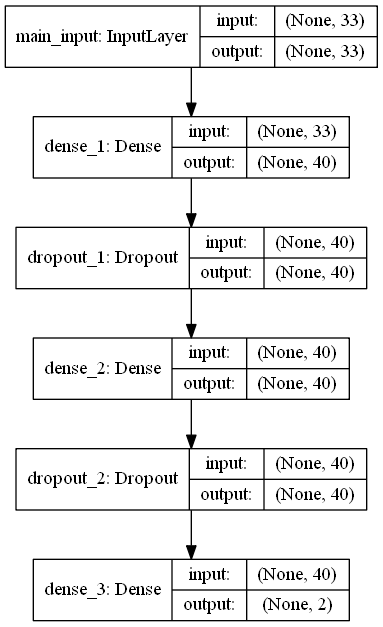

In [16]:
IPython.display.Image("images/ionosphere_nn.png")

In [17]:
model.fit(x_train, y_train, 
          batch_size=batchsize,
          epochs=epochsize,
          verbose=0,
          shuffle=shuffle,
         validation_split=0.05)
nn_score = model.evaluate(x_val, y_val)[1]
print(nn_score)

35/35 [==============================] - 0s 86us/step
0.914285714286


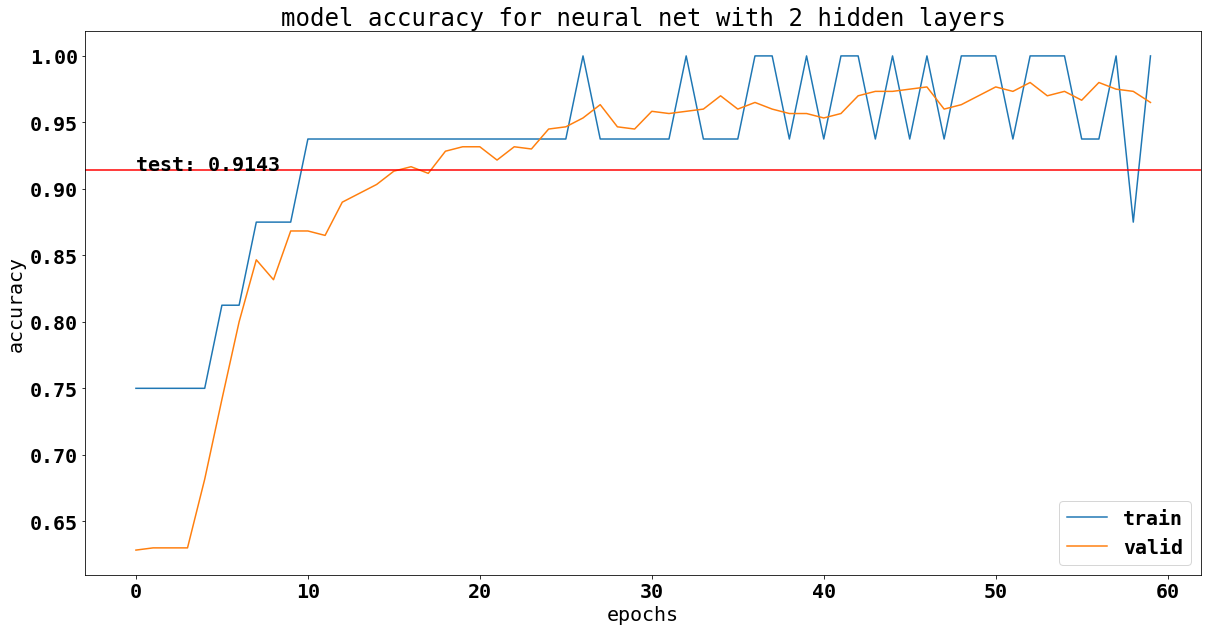

In [18]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['acc'])
plt.axhline(y=nn_score, c="red")
plt.text(0, nn_score, "test: " + str(round(nn_score, 4)), fontdict=font)
plt.title('model accuracy for neural net with 2 hidden layers')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

In [19]:
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_eval, model.predict(x_val).argmax(axis=-1))
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[10  1]
 [ 2 22]]


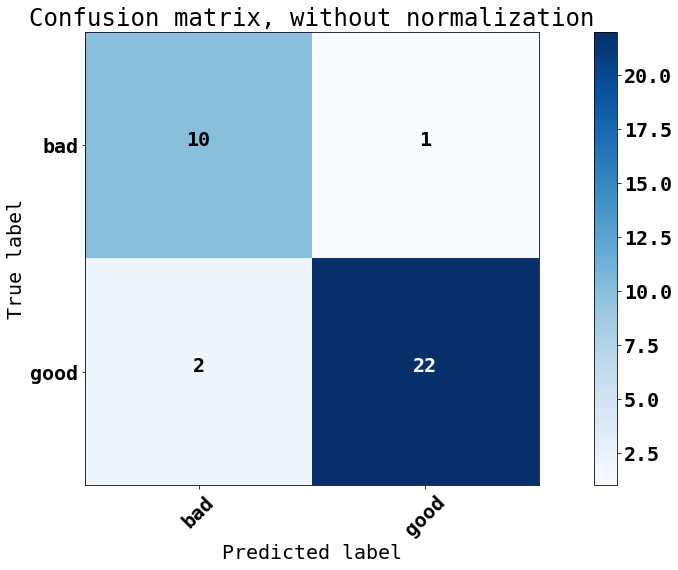

In [21]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix, classes=['bad', 'good'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.91  0.09]
 [ 0.08  0.92]]


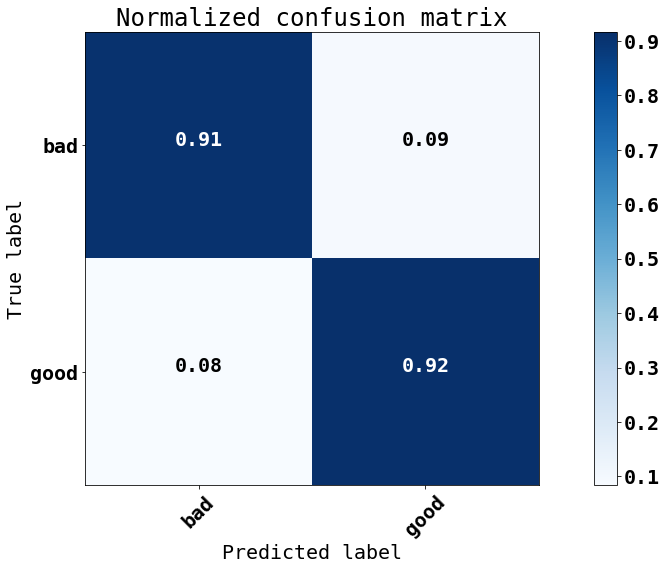

In [22]:
# Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cnf_matrix, classes=['bad', 'good'], normalize=True,
                      title='Normalized confusion matrix')

## Whats the best dimensionality reduction with single autoencoder?

In [23]:
# the initial coding dimension s.t. there is no dim reduction at the beginning
encoding_dim = input_dim
result = {'encoding_dim': []
           ,'auto_classifier_acc': []}

In [ ]:
while encoding_dim > 0:
    main_input = Input(shape=(input_dim,), dtype='float32', name='main_input')

    encoding_layer = Dense(encoding_dim, activation='relu', name='encoder', kernel_initializer='normal')
    encoding_layer_output = encoding_layer(main_input)
    decoding_layer_output = Dense(input_dim, activation='sigmoid'
                                  ,name='decoder_output'
                                  ,kernel_initializer='normal')(encoding_layer_output)

    x = Dense(hidden1_dim, activation='relu', kernel_initializer=weight_init)(encoding_layer_output)
    x = Dropout(dropout)(x)
    x = Dense(hidden2_dim, activation='relu', kernel_initializer=weight_init)(x)
    x = Dropout(dropout)(x)

    classifier_output = Dense(num_classes, activation='sigmoid', name='main_output', kernel_initializer=weight_init)(x)

    auto_classifier = Model(inputs=main_input, outputs=[classifier_output, decoding_layer_output])

    auto_classifier.compile(optimizer=RMSprop(),
                            loss={'main_output': 'binary_crossentropy', 'decoder_output': 'mean_squared_error'},
                            loss_weights={'main_output': .5, 'decoder_output': .5},
                            metrics=['accuracy'])

    auto_classifier.fit({'main_input': x_train},
                        {'main_output': y_train, 'decoder_output': x_train},
                        epochs=epochsize, 
                        batch_size=batchsize,
                        shuffle=shuffle,
                        validation_split=0.05,
                        verbose=0)

    accuracy = auto_classifier.evaluate(x=x_val, y=[y_val, x_val], verbose=1)[3]
    result['encoding_dim'].append(encoding_dim)
    result['auto_classifier_acc'].append(accuracy)
    
    encoding_dim -=1

In [27]:
result_df = pd.DataFrame(result)
result_df['neural_net_acc'] = nn_score
result_df.head()

,auto_classifier_acc,encoding_dim,neural_net_acc
0,0.885714,33,0.914286
1,0.942857,32,0.914286
2,0.828571,31,0.914286
3,0.885714,30,0.914286
4,0.885714,29,0.914286


(0.6, 1)

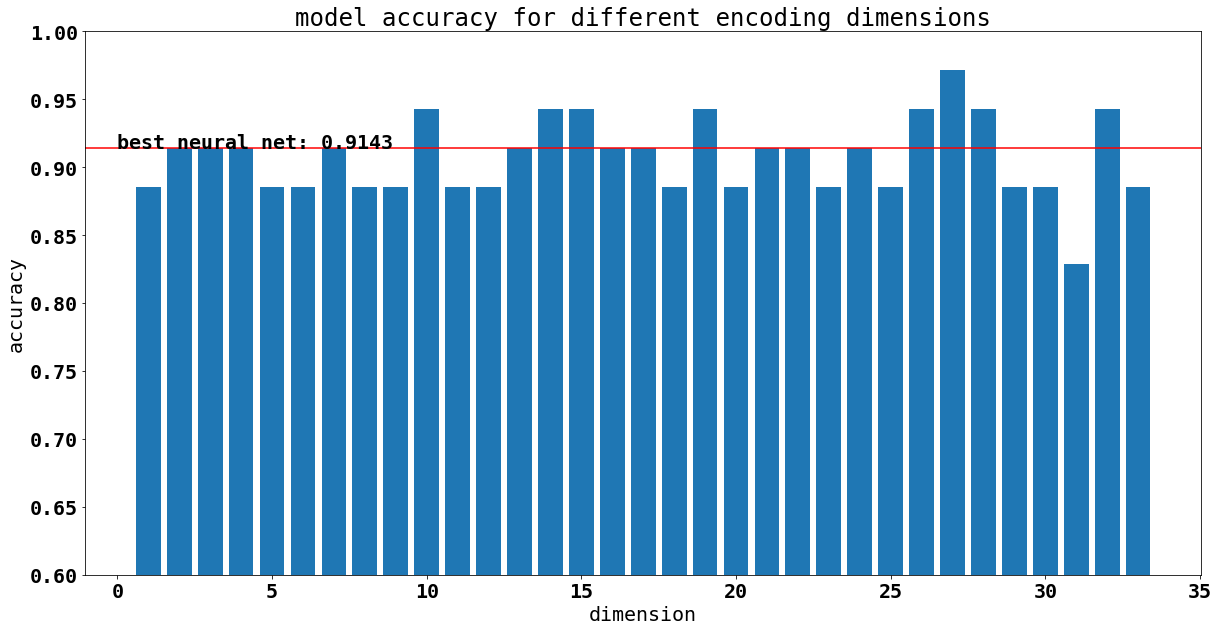

In [28]:
fig = plt.figure(figsize=(20,10))
plt.bar(result_df['encoding_dim'], result_df['auto_classifier_acc'])
plt.axhline(y=result_df['neural_net_acc'][0], c="red")
plt.text(0, result_df['neural_net_acc'][0], "best neural net: " + str(round(result_df['neural_net_acc'][0], 4))
         ,fontdict=font)
plt.title('model accuracy for different encoding dimensions')
plt.ylabel('accuracy')
plt.xlabel('dimension')
plt.ylim(0.6, 1)